 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Output-FileName" data-toc-modified-id="Output-FileName-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Output FileName</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Historical-Data" data-toc-modified-id="Historical-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Historical Data</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Realtime-Data" data-toc-modified-id="Realtime-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Realtime Data</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Concatenate-Historical-and-Real" data-toc-modified-id="Concatenate-Historical-and-Real-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Concatenate Historical and Real</a></span></li></ul></div>

Process Hydrographic Canada downloaded files to produce river files

# Imports #

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Output FileName #

In [14]:
filename = 'Nicomekl_203'

# Historical Data #

In [15]:
data = pd.read_csv('Daily__Jan-7-2021_02_08_28AM.csv', skiprows=1)
data = data[data.PARAM == 1]
data = data.set_index('Date')
data = data.drop([' ID', 'PARAM'], axis=1)
data[-5:]

,Value,SYM
Date,,
2017/12/27,1.05,NaN
2017/12/28,4.87,NaN
2017/12/29,14.10,NaN
2017/12/30,13.60,NaN
2017/12/31,3.87,NaN


In [16]:
year, month, day = [], [], []
for i, index in enumerate(data.index):
    year.append(index[0:4])
    month.append(index[5:7])
    day.append(index[8:10])

In [17]:
outdata = pd.DataFrame({'year': year, 
                        'month':month, 
                        'day': day,
                        'discharge': data.Value, 
                        'comment': data.SYM}, columns=['year', 'month', 'day', 
                                                       'discharge', 'comment'])

In [18]:
outdata[-5:]

,year,month,day,discharge,comment
Date,,,,,
2017/12/27,2017,12,27,1.05,NaN
2017/12/28,2017,12,28,4.87,NaN
2017/12/29,2017,12,29,14.10,NaN
2017/12/30,2017,12,30,13.60,NaN
2017/12/31,2017,12,31,3.87,NaN


# Realtime Data #

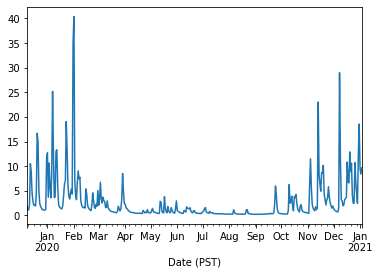

In [19]:
rtdata = pd.read_csv('08MH155_QR_Jan-7-2021_02_03_29AM.csv', skiprows=9)
rtdata['Date (PST)'] = pd.to_datetime(rtdata['Date (PST)'])
rtdata.set_index('Date (PST)')
rtdata = rtdata.resample('d', on='Date (PST)').mean().dropna(how='all')
rtdata = rtdata.drop(['Parameter '], axis=1)
rtdata['Value (m3/s)'].plot();

In [20]:
rtoutdata = pd.DataFrame({'year': rtdata.index.year, 
                        'month': rtdata.index.month, 
                        'day': rtdata.index.day,
                        'discharge': rtdata['Value (m3/s)']}, columns=['year', 'month', 'day', 
                                                       'discharge'])

# Concatenate Historical and Real #

In [21]:
result = pd.concat([outdata, rtoutdata])

In [22]:
result.to_csv(path_or_buf=filename, sep=' ', 
               columns=['year', 'month', 'day', 'discharge', 'comment'], 
               header=False, index=False, float_format="%.6E")


In [23]:
alltogether = pd.read_csv(filename, header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])

In [24]:
alltogether.index = pd.to_datetime(alltogether.drop(['Flow'], axis=1))

<AxesSubplot:>

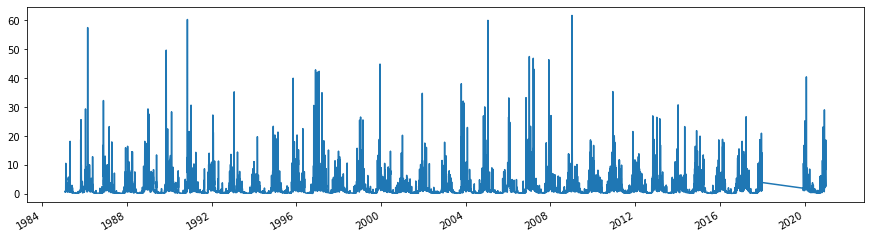

In [25]:
alltogether.Flow.plot(figsize=(15,4))#xlim=(datetime.date(2007, 1, 1), datetime.date(2019, 4, 5)));

In [295]:
diversion = pd.read_csv('Theodosia_Diversion_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
diversion.index = pd.to_datetime(diversion.drop(['Flow'], axis=1))

In [316]:
bypass = pd.read_csv('Theodosia_Bypass_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
bypass.index = pd.to_datetime(bypass.drop(['Flow'], axis=1))

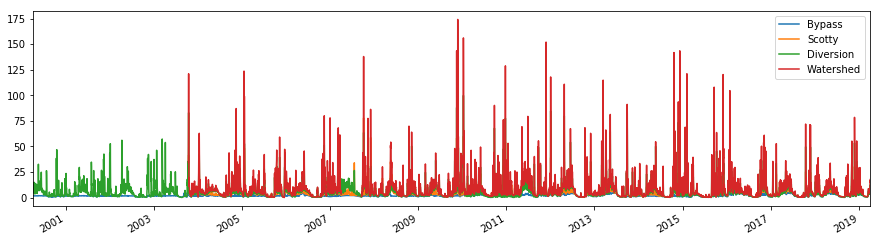

In [317]:
bypass.Flow.plot(figsize=(15,4), label='Bypass')
alltogether.Flow.plot(figsize=(15,4), label='Scotty')
diversion.Flow.plot(label='Diversion')
(diversion.Flow + alltogether.Flow - bypass.Flow).plot(label='Watershed')
plt.legend()

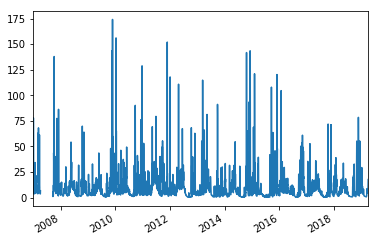

In [319]:
(diversion.Flow + alltogether.Flow - bypass.Flow).plot(
    xlim=(datetime.date(2007, 1, 1), datetime.date(2019, 4, 5)));

In [320]:
(diversion.Flow + alltogether.Flow - bypass.Flow).min()

0.097000000000000086

In [321]:
Bute = pd.read_csv('Homathko_Mouth_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
Bute.index = pd.to_datetime(Bute.drop(['Flow'], axis=1))

In [332]:
Bute = Bute.resample('A-JAN').mean().dropna(how='all')

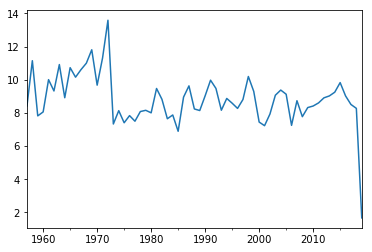

In [337]:
(Bute.Flow*86400*365/1e9).plot()

In [340]:
(Bute.Flow*86400*365/1e9)[:-1].mean()

8.937704975408858

In [341]:
Bute.Flow[:-1].mean()

283.4127655824727